#Deep Learning - :Neural Network Class

*__Submission Instructions:__*
- Rename this notebook to `PA2_HW1_Rollnumber.ipynb` before submission on LMS.
- All code must be written in this notebook (you do not need to submit any other files).
- The output of all cells must be present in the version of the notebook you submit. You will be penalized if the output is absent.
- The university honor code should be maintained. Any violation, if found, will result in disciplinary action. 
- You have to download assignment from LMS and do all your workings on colab. Don't download the files again and again.
- You can share the notebook link of your colab noteboob in the begining of the notebook.

In [2]:
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import Image
import pydot
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.datasets import make_moons
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf

**Please write your roll number in the next cell**

In [3]:
rollnumber = 21030008

In this assignment you will be creating 4 versions of the `NeuralNetwork` class. You will start with a simple 3 layer feed forward network and progressively modify the class by adding features to make it more generic. At the end you will have implemented a version which can create networks of arbitrary shape and depth, and which will work for both regression and classification tasks. 

Often in pratical situations, raw machine learning architecture and code is hidden behind libraries and simplfied toolkits. The purpose of this assignment is to lift that curtain and get you hands-on exprience working with the mathematical fundamentals of neural network architectures. After this, you'll know exactly how a network leverages 'gradient descent' to find optimal solutions and how forward and backward passes are implemented mathematically and in code.


### Primary Task
Skeleton code is provided to get you started; the main methods you need to implement correspond to the 3 steps of the training process, namely:
1. Initialize variables and initialize weights
2. Forward pass
3. Backward pass AKA Backpropogation
4. Weight Update AKA Gradient Descent

__Look for comments in the code to see where you are supposed to write code.__ Essentially, you will be working on 5 functions. 
You should use the lecture slides as reference for the equations. 

A `fit` function is what combines the previous three functions and overall trains the network to __fit__ to the provided training examples. In all the following tasks, the provided `fit` methods require the three steps of the training process to be correctly working. The function has been setup in a way that it expects the above 3 methods to take particular inputs and return particular outputs. __You are supposed to work within this restriction.__ Modification of the provided code without prior discussion with the TAs will result in a __grade deduction__. 



To see how well your model is doing, you need to look at the dummy tasks (at the end) and make sure your model loss is going down during training. A dummy regression task of adding two numbers (sum less than 1) has been provided as well. Similarly, a dummy classification task (XOR logic gate) is also present. You can look at the shapes of the inputs and outputs matrices as well as the training trend (once you implement a full task) by using your own class (make sure you are using the correct arguments to the `__init__` method). 

You can find a demonstration of the neural network working on a synthetic dataset for both regression and classification at the end of the notebook. After you implement your class fully, you can play with the parameters and see the visualization change, we highly recommend that you try this. This part of the notebook will not be graded in any way, but it might give you a better insight/intuition into how the model makes decisions, and how important parameters are in terms of the usefullness of neural networks. You will explore the parameter space more thoroughly in the next assignment :P

### Side note
*The `plot_model` method will only work if you have the `pydot` python package installed along with [Graphviz](https://graphviz.gitlab.io/download/)). If you do not wish to use this then simply comment out the import for `pydot`.*

### Need Help?
If you need help, refer to your textbook (provided on LMS) which has examples and explanations for all the processes you'll have to implement, as well as rich details on functions such as `sigmoid` and `softmax`. Going over the book once before getting started is a good idea, you can also refer to the class slides and supplemental material provided with the assignment.

## Task 1

In this task you will implement the simplest version of a feed forward neural network - a 3 layer network. 

Your code will only be partially vectorized, this means that you will be passing a single data point through the network at a time. In simple terms, the running time of your `fit` method will be $O(e*n)$ where $e$ is the number of epochs and $n$ is the number of data points (assuming all functions/methods called in `fit` take constant time). 

This version of the network will be using the `softmax` activation function for the output layer and `sigmoid` for the hidden layer, *ie.* a classification model which learns to output the joint probability mass function of the classes in the dataset. 

In [116]:
def plot_confusion_matrix(conf_mat):
    classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

class_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


In [117]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        # implement mean_squared_error function
        mse = np.square(np.subtract(y_true,y_pred)).mean()
        return mse
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        # implement cross_entropy_loss function
        entropy_loss = -np.mean(y_true*np.log(y_pred))
        return entropy_loss
    
    @staticmethod
    def accuracy(y_pred, y_true):
        # implement accuracy function
        return np.sum(y_pred == y_true)
    
    @staticmethod
    def softmax(x):
        # implement softmax function
        sof_n = np.exp(x)
        soft = sof_n/np.sum(sof_n)
        return soft
    
    
    @staticmethod
    def sigmoid(x):
        # implement sigmoid function
        return 1/(1+np.exp(-x))
        
    
    def __init__(self, nodes_per_layer, mode):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 3:
            raise ValueError('Network must have atleast 3 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.mode = mode
        
        
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            
            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],))
            self.biases_.append(bias_vector)
    

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        x = np.dot(input_data,self.weights_[0])+self.biases_[0]
        activations.append(self.sigmoid(x))
        x = np.dot(activations[0],self.weights_[1])+self.biases_[1] 
        activations.append(self.sigmoid(x))
        x = np.dot(activations[1],self.weights_[2])+self.biases_[2]
        activations.append(self.softmax(x))   
        return activations

        
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        delta3 = np.multiply(layer_activations[2]-targets ,layer_activations[2]*(1-layer_activations[2]))
        delta2 = np.multiply(np.dot(self.weights_[2],delta3.T).T ,layer_activations[1]*(1-layer_activations[1]))
        delta1 = np.multiply(np.dot(self.weights_[1],delta2.T).T ,layer_activations[0]*(1-layer_activations[0]))
        deltas = [delta1,delta2,delta3]


        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        for i in range(len(layer_inputs)-1):
            self.weights_[i] = self.weights_[i] - lr*(deltas[i].T*layer_inputs[i]).T
            self.biases_[i] = self.biases_[i] - lr*np.sum(deltas[i])
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        print(Xs.shape)
        print(Ys.shape)
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                sample_input = Xs[i,:].reshape((1,self.input_shape))
                sample_target = Ys[i,:].reshape((1,self.output_shape))
                
                activations =  self.forward_pass(sample_input) # Call forward_pass function  
                deltas =  self.backward_pass(sample_target,activations) # Call backward_pass function  

                layer_inputs = [sample_input] + activations[:-1]
                self.weight_update(deltas,layer_inputs,lr) # Call weight_update function  
            preds = self.predict(Xs) # Call predict function 
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)


In [118]:

classes = 10
#Download Fashion cifar10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Split the fashion cifar10 dataset into train, validation and test sets (Done for you)
#Convert y_train,y_val and y_test to categorical binary values 



X_train, y_train = X_train[1:15361], y_train[1:15361]
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

#Reshape images of X_train and X_test to 1d array

#TO DO
print(X_train.shape)
X_train = X_train.reshape(15360,32*32*3)
X_test = X_test.reshape(10000,32*32*3)


#See function of numpy reshape
# Mean Normalisation as asked by the TA
X_train = (X_train - X_train.mean(axis=1)[:,np.newaxis])
X_train = X_train/X_train.std(axis=1)[:,np.newaxis]
X_test = X_test - X_test.mean(axis=1)[:,np.newaxis]
X_test = X_test/X_test.std(axis=1)[:,np.newaxis]

(5000, 3072)
(5000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/200 [00:00<?, ?it/s]

Runtime of the algorithm is  1248.127  seconds


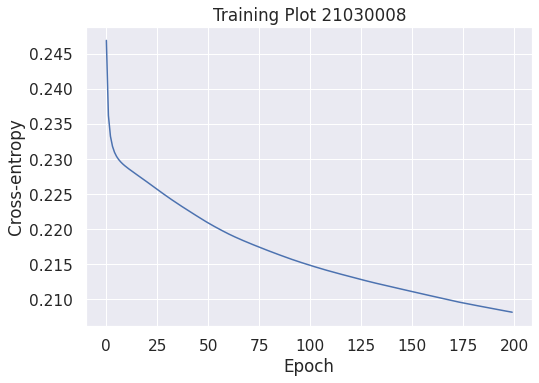

In [119]:

# starting time
start = time.time()
# Define the input size and output size of  Fashion cifar10 dataset

nn = NeuralNetwork([3072,30,10,10], 'classification')
# You can tweak the learning rate and epochs to know how things work
history = nn.fit(X_train, y_train, epochs=200, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));
# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

## Task 2

Now you will modify the class to allow the option to learn a regression model. You need to change some methods to account for the `mode` of the network. You can copy your code from task 1 as a starting point if you want.

If the `mode` is classification, you will use your code from Task1. In case of the `mode` being regression you will apply the `sigmoid` activation function to both layers and compute the deltas for that.

In [120]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        # implement mean_squared_error function
        mse = np.square(np.subtract(y_true,y_pred)).mean()
        return mse
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        # implement cross_entropy_loss function
        entropy_loss = -np.mean(y_true*np.log(y_pred))
        return entropy_loss
    
    @staticmethod
    def accuracy(y_pred, y_true):
        # implement accuracy function
        return np.sum(y_pred == y_true)
    
    @staticmethod
    def softmax(x):
        # implement softmax function
        sof_n = np.exp(x)
        soft = sof_n/np.sum(sof_n)
        return soft
    
    
    @staticmethod
    def sigmoid(x):
        # implement sigmoid function
        return 1/(1+np.exp(-x))
        
    
    
    def __init__(self, input_size, hidden_nodes, output_size, mode):
        '''Creates a Feed-Forward Neural Network.
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric
        The rest of the parameters represent the number of nodes in each layer (total 3).'''
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        
        self.num_layers = 3 # includes input layer
        self.input_shape = input_size
        self.hidden_shape = hidden_nodes
        self.output_shape = output_size
        self.mode = mode
        


        
        self.weights_ = self.biases_ = []
        self.__init_weights()
    
    def __init_weights(self):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        W_h = np.random.normal(size=(self.input_shape,self.hidden_shape))
        b_h = np.zeros(shape=(self.hidden_shape,))
        
        W_o = np.random.normal(size=(self.hidden_shape,self.output_shape))
        b_o = np.zeros(shape=(self.output_shape,))
        
        self.weights_ = [W_h,W_o]
        self.biases_  = [b_h,b_o]

    
    

    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        x = np.dot(input_data,self.weights_[0])+self.biases_[0]
        activations.append(self.sigmoid(x))
        x = np.dot(activations[0],self.weights_[1])+self.biases_[1] 
        if self.mode=='classification': activations.append(self.softmax(x)) 
        else: activations.append(self.sigmoid(x))   
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        delta2 = np.multiply(layer_activations[1]-targets ,layer_activations[1]*(1-layer_activations[1]))
        delta1 = np.multiply(np.dot(self.weights_[1],delta2.T).T ,layer_activations[0]*(1-layer_activations[0]))
        deltas = [delta1,delta2]
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        for i in range(len(layer_inputs)-1):
          self.weights_[i] = self.weights_[i] - lr*(deltas[i].T.dot(layer_inputs[i])).T
          self.biases_[i] = self.biases_[i] - lr*np.sum(deltas[i])
        
        
    
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                if(i+2 <= num_samples):
                    sample_input = Xs[i:i+2,:].reshape((1,self.input_shape))
                    sample_target = Ys[i,:].reshape((1,self.output_shape))
                
                    activations = self.forward_pass(sample_input) # Call forward_pass function  
                    deltas = self.backward_pass(sample_target,activations) # Call backward_pass function

                    layer_inputs = [sample_input] + activations[:-1]
                    # Call weight_update function
                    self.weight_update(deltas,layer_inputs,lr)

            preds = self.predict(Xs)  # Call predict function 
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys[:-1])
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys[:-1])
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            if(i+2 <= num_samples):
                sample = Xs[i:i+2,:].reshape((1,self.input_shape))
                sample_prediction = self.forward_pass(sample)[-1]
                predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        nodes_per_layer = [self.input_shape, self.hidden_shape, self.output_shape]
        for i in range(self.num_layers-1):
            for n1 in range(nodes_per_layer[i]):
                for n2 in range(nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

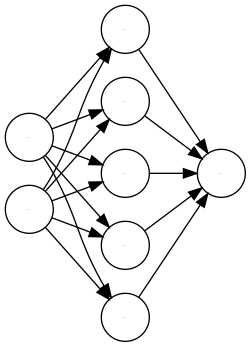

In [121]:
nn = NeuralNetwork(input_size=2, hidden_nodes=5, output_size=1, mode='regression')
nn.plot_model('graph.png')
Image('graph.png')

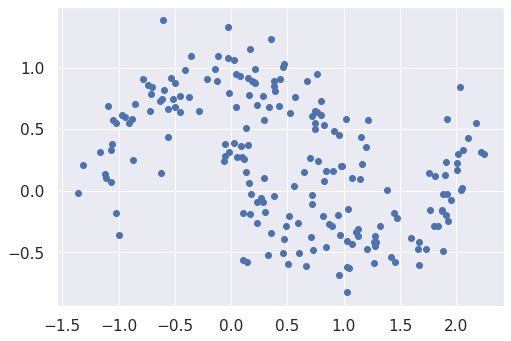

In [122]:
data_x, _ = make_moons(200, noise=0.18)
plt.scatter(data_x[:,0], data_x[:,1]);

In [123]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));

d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

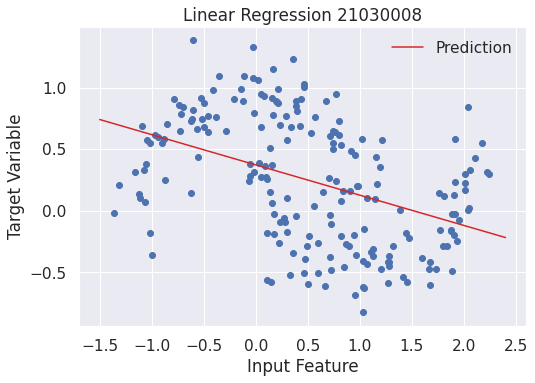

In [124]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}'.format(rollnumber));
ax.legend();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/200 [00:00<?, ?it/s]

Runtime of the algorithm is  3.295  seconds


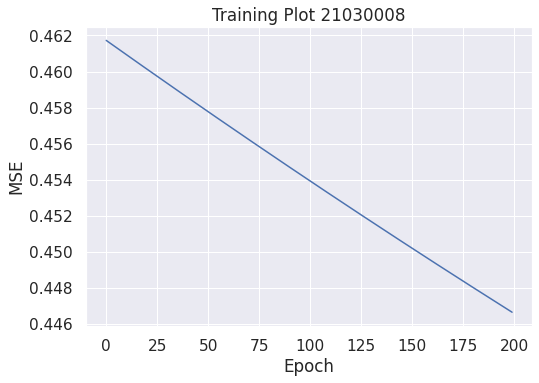

In [125]:

# starting time
start = time.time()

nn = NeuralNetwork(input_size=2, hidden_nodes=6, output_size=1, mode='regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=200, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}'.format(rollnumber));
# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

## Task 3

Again, if it helps copy only your code from Task2 as a starting point in the next cell. Now you will modify the class to allow an arbitrarily shaped network. 

*Hint: The output/last layer is special in terms of the delta calculation. All the hidden layers have the same calculation (chain rule)*

In [126]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        # implement mean_squared_error function
        mse = np.square(np.subtract(y_true,y_pred)).mean()
        return mse
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        # implement cross_entropy_loss function
        entropy_loss = -np.mean(y_true*np.log(y_pred))
        return entropy_loss
    
    @staticmethod
    def accuracy(y_pred, y_true):
        # implement accuracy function
        return np.sum(y_pred == y_true)
    
    @staticmethod
    def softmax(x):
        # implement softmax function
        sof_n = np.exp(x)
        soft = sof_n/np.sum(sof_n)
        return soft
    
    
    @staticmethod
    def sigmoid(x):
        # implement sigmoid function
        return 1/(1+np.exp(-x))
        
    
    def __init__(self, nodes_per_layer, mode):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')

        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.mode = mode
        
        
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],))
            self.biases_.append(bias_vector)
    

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        x = np.dot(input_data,self.weights_[0])+self.biases_[0]
        activations.append(self.sigmoid(x))
        for i in range(1,self.num_layers-2):
          x = np.dot(activations[i-1],self.weights_[i])+self.biases_[i]
          activations.append(self.sigmoid(x))
        x = np.dot(activations[-1],self.weights_[-1])+self.biases_[-1]
        if self.mode=='classification': activations.append(self.softmax(x)) 
        else: activations.append(self.sigmoid(x))          
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = []
        x = np.multiply(layer_activations[-1]-targets ,layer_activations[-1]*(1-layer_activations[-1]))
        deltas.append(x)
        for i in range(len(layer_activations),0,-1):
          if i == len(layer_activations): continue

          x = np.multiply((np.dot(self.weights_[i],x.T)).T ,layer_activations[i-1]*(1-layer_activations[i-1]))
          deltas.append(x)
        deltas.reverse()
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        for i in range(self.num_layers-1):
          self.weights_[i] = self.weights_[i] - lr*(deltas[i].T.dot(layer_inputs[i])).T
          self.biases_[i] = self.biases_[i] - lr*np.sum(deltas[i])
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        print(Xs.shape)
        print(Ys.shape)
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                sample_input = Xs[i,:].reshape((1,self.input_shape))
                sample_target = Ys[i,:].reshape((1,self.output_shape))
                
                activations =  self.forward_pass(sample_input) # Call forward_pass function  
                deltas =  self.backward_pass(sample_target,activations) # Call backward_pass function  

                layer_inputs = [sample_input] + activations[:-1]
                self.weight_update(deltas, layer_inputs,lr) # Call weight_update function  
            preds = self.predict(Xs) # Call predict function 
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)


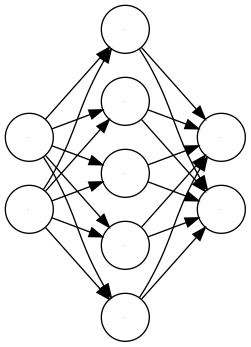

In [127]:
nn = NeuralNetwork([2,5,2], 'classification')
nn.plot_model('graph.png')
Image('graph.png')

(4, 2)
(4, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3000 [00:00<?, ?it/s]

Runtime of the algorithm is  1.682  seconds


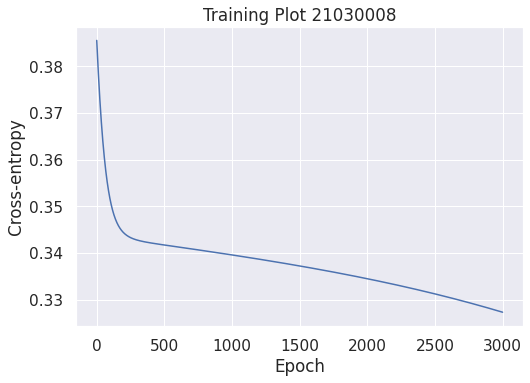

In [128]:


dataset = pd.DataFrame({
    'var1':   [0, 0, 1, 1],
    'var2':   [0, 1, 0, 1],
    'output': [0, 1, 1, 0],
})
dataset = pd.get_dummies(dataset, columns=['output'])
dataset['output'] = pd.Series([0, 1, 1, 0])

# starting time
start = time.time()
nn = NeuralNetwork([2,5,2], 'classification')
history = nn.fit(dataset[['var1','var2']].values, dataset[['output_0','output_1']].values, epochs=3000, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));
# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

## Task 4

Again, if it helps copy only your code from Task3 as a starting point in the next cell. To cap off this assignment you will fully vectorize your implementation. This means changing the primary functions again. 
After you do this, the runtime of the `fit` function will just be $O(e)$ (again, assuming all functions called in the loop take constant time).

In [168]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        # implement mean_squared_error function
        mse = np.square(np.subtract(y_true,y_pred)).mean()
        return mse
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        # implement cross_entropy_loss function
        entropy_loss = -np.mean(y_true*np.log(y_pred))
        return entropy_loss
    
    @staticmethod
    def accuracy(y_pred, y_true):
        # implement accuracy function
        return np.sum(y_pred == y_true)
    
    @staticmethod
    def softmax(x):
        # implement softmax function
        sof_n = np.exp(x)
        soft = sof_n/np.sum(sof_n)
        return soft
    
    
    @staticmethod
    def sigmoid(x):
        # implement sigmoid function
        return 1/(1+np.exp(-x))
    
    
    def __init__(self, nodes_per_layer, mode,confusion_matrix):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        

        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.mode = mode
        self.confusion_matrix=confusion_matrix
        
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue

            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],))
            self.biases_.append(bias_vector)
    

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        x = np.dot(input_data,self.weights_[0])+self.biases_[0]
        activations.append(self.sigmoid(x))
        for i in range(1,self.num_layers-2):
          x = np.dot(activations[i-1],self.weights_[i])+self.biases_[i]
          activations.append(self.sigmoid(x))
        x = np.dot(activations[-1],self.weights_[-1])+self.biases_[-1]
        if self.mode=='classification': activations.append(self.softmax(x)) 
        else: activations.append(self.sigmoid(x))

        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = []
        x = np.multiply(layer_activations[-1]-targets ,layer_activations[-1]*(1-layer_activations[-1]))
        deltas.append(x)
        for i in range(len(layer_activations),0,-1):
          if i == len(layer_activations): continue

          x = np.multiply((np.dot(self.weights_[i],x.T)).T ,layer_activations[i-1]*(1-layer_activations[i-1]))
          deltas.append(x)
        deltas.reverse()
        return deltas

    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        for i in range(self.num_layers-1):
          self.weights_[i] = self.weights_[i] - lr*(deltas[i].T.dot(layer_inputs[i])).T
          self.biases_[i] = self.biases_[i] - lr*np.sum(deltas[i])


    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        print(Xs.shape)
        print(Ys.shape)
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                sample_input = Xs[i,:].reshape((1,self.input_shape))
                sample_target = Ys[i,:].reshape((1,self.output_shape))

            ## implement batch . Remove sample by sample
            #sample_input = Xs
            #sample_target = Ys    
                activations =  self.forward_pass(sample_input) # Call forward_pass function  
                deltas =  self.backward_pass(sample_target,activations) # Call backward_pass function  

                layer_inputs = [sample_input] + activations[:-1]
                self.weight_update(deltas, layer_inputs,lr) # Call weight_update function  
            preds = self.predict(Xs) # Call predict function 
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            if  (epoch==epochs-1) and (self.mode == 'classification') and (self.confusion_matrix==True):
                  confusion_mat=confusion_matrix(Ys.argmax(axis=1), preds.argmax(axis=1))  
                  plot_confusion_matrix(confusion_mat)
                  report = classification_report(Ys, np_utils.to_categorical(preds.argmax(axis=1)), target_names=class_labels)
                  print(report)
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
        #return sample_prediction
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)


### Classification for Task4

You will repeat the classfication task on Cifar10 dataset. You can change the hidden layers and their sizes to acheive the optimal results. We have passed the confusion_matrix=True for this classification task only.

(5000, 3072)
(5000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/120 [00:00<?, ?it/s]

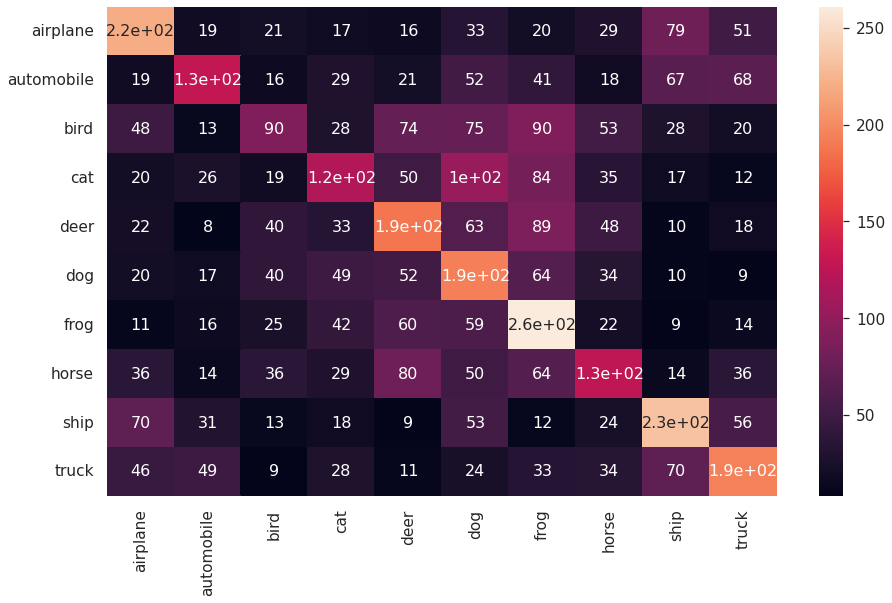

              precision    recall  f1-score   support

    airplane       0.43      0.44      0.43       505
  automobile       0.40      0.28      0.33       460
        bird       0.29      0.17      0.22       519
         cat       0.30      0.24      0.27       486
        deer       0.34      0.36      0.35       519
         dog       0.27      0.40      0.32       488
        frog       0.34      0.50      0.41       519
       horse       0.30      0.26      0.28       486
        ship       0.43      0.45      0.44       520
       truck       0.41      0.39      0.40       498

   micro avg       0.35      0.35      0.35      5000
   macro avg       0.35      0.35      0.35      5000
weighted avg       0.35      0.35      0.35      5000
 samples avg       0.35      0.35      0.35      5000

Runtime of the algorithm is  552.09  seconds


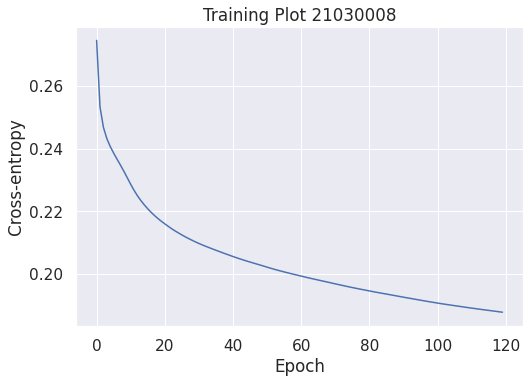

In [170]:
# starting time
start = time.time()
# Define the input size and output size of Cifar10 dataset

# You can change the number of hidden layers and their sizes  to get the optimal results

nn = NeuralNetwork(nodes_per_layer=[3072,20,20,10],mode='classification',confusion_matrix=True)
#NuralNetwork(nodes_per_layer=[None,None,None],mode='classification',confusion_matrix=True)
# You can tweak the learning rate and epochs to get the optimal results
history = nn.fit(X_train, y_train, epochs=120, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));
# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

### Regression for Task4

In [109]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

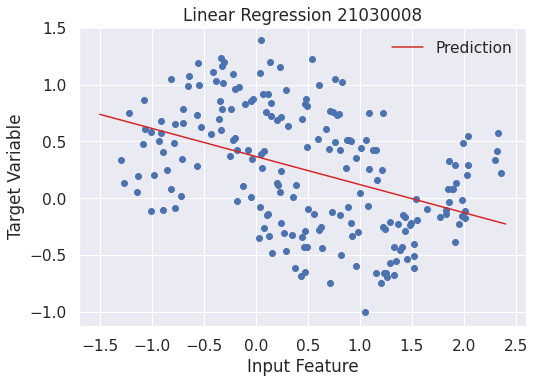

In [110]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}'.format(rollnumber));
ax.legend();

In [167]:
########################################### ALL BELOW IRRELEVENT 
# starting time
start = time.time()

nn = NeuralNetwork([1,10,20,10,1], 'regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=2000, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}'.format(rollnumber));
# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

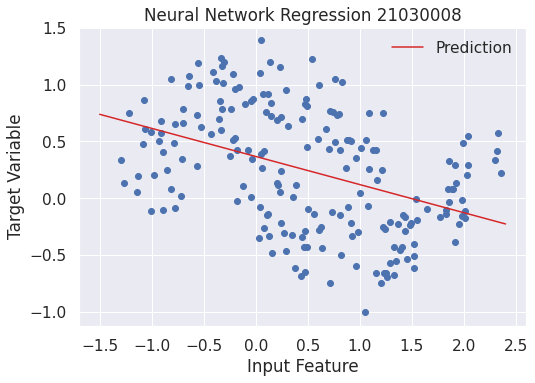

In [112]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}'.format(rollnumber));
ax.legend();

## Dummy Regression Task

In [113]:
a = np.random.uniform(low=0.0, high=0.5, size=(150,))
b = np.random.uniform(low=0.0, high=0.5, size=(150,))
dataset = pd.DataFrame({
    'var1':   a,
    'var2':   b,
    'output': a+b,
})
print(dataset.shape)
dataset.head()

(150, 3)


,var1,var2,output
0,0.357289,0.067974,0.425263
1,0.415304,0.496221,0.911524
2,0.416575,0.481904,0.898479
3,0.235031,0.059515,0.294545
4,0.071154,0.249588,0.320742


In [170]:
nn = NeuralNetwork([2,3,5,1], 'regression')
nn.plot_model('graph.png')
Image('graph.png')

In [170]:
history = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, epochs=2000, lr=0.001)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}'.format(rollnumber));

In [170]:
test_data = np.array([[0.4,0.1],
                      [0.2,0.3]])
nn.predict(test_data)

## Dummy Classification Task

In [170]:
# XOR logic operator
dataset = pd.DataFrame({
    'var1':   [0, 0, 1, 1],
    'var2':   [0, 1, 0, 1],
    'output': [0, 1, 1, 0],
})
dataset = pd.get_dummies(dataset, columns=['output'])
dataset['output'] = pd.Series([0, 1, 1, 0])
print(dataset.shape)
dataset.head()
# The columns 'output_0' and 'output_1' are one-hot encoded representation of the categorical column 'output'

In [170]:
nn = NeuralNetwork([2,5,2], 'classification')
nn.plot_model('graph.png')
Image('graph.png')

In [170]:
history = nn.fit(dataset[['var1','var2']].values, dataset[['output_0','output_1']].values, epochs=3000, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));

In [170]:
nn.predict(dataset[['var1','var2']].values).argmax(axis=1) == dataset[['output_0','output_1']].values.argmax(axis=1)

## Regression Demo

Code for Demos adapted from tutorial 1, refer to it if you need a refresher (available on LMS)

In [ ]:
data_x, _ = make_moons(200, noise=0.18)
plt.scatter(data_x[:,0], data_x[:,1]);

In [ ]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));

d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}'.format(rollnumber));
ax.legend();

In [ ]:
nn = NeuralNetwork([1,10,20,10,1], 'regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=20000, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}'.format(rollnumber));

In [ ]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}'.format(rollnumber));
ax.legend();

## Classification Demo

In [ ]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry
def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

In [ ]:
data_x, data_y = make_moons(200, noise=0.20)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2');

In [ ]:
clf = LogisticRegression(solver='lbfgs')
clf = clf.fit(data_x, data_y);

In [ ]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: clf.predict(x), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title='Logistic Regression Classifier {}'.format(rollnumber));

In [ ]:
nn = NeuralNetwork([2,10,10,2], 'classification')
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=2000, lr=1e-3)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));

In [ ]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title='Neural Network Classifier {}'.format(rollnumber));